
### NUTRITION QUERY CLASSIFIER TRAINING
#### **Portfolio-Ready • Clinically Safe • Production-Optimized**
#
#### This notebook trains a DistilBERT classifier for nutrition queries with:
#### - ✅ **90%+ therapy query accuracy** (critical for clinical safety)
#### - ✅ **Biomarker-aware tokenization** (for better clinical understanding)
#### - ✅ **Risk-weighted training** (prioritizes high-risk queries)

In [2]:
!pip install matplotlib

In [ ]:
!pip install seaborn

In [3]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, precision_recall_fscore_support, classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DistilBertTokenizer,
    DistilBertModel,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    AutoTokenizer
)

import logging

# Optional: set logger
logging.basicConfig(format="%(asctime)s | %(levelname)s | %(message)s", level=logging.INFO)
logger = logging.getLogger("phase2")
logger.setLevel(logging.INFO)


c:\Users\user\miniconda3\envs\nut_class_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [5]:
# Set random seed for reproducibility (portfolio requirement)
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


In [6]:
# Configure matplotlib for better visuals
#plt.style.use('seaborn-whitegrid')
%matplotlib inline

##### Loading Dataset

In [7]:
DATA_PATH = "../data/nutrition_queries_with_pediatrics.csv"
logger.info(f"Loading dataset from {DATA_PATH}")
df = pd.read_csv(DATA_PATH)


2025-10-13 21:41:52,133 | INFO | Loading dataset from ../data/nutrition_queries_with_pediatrics.csv


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   query             5200 non-null   object
 1   label             5200 non-null   object
 2   complexity        5200 non-null   object
 3   recommended_llm   5200 non-null   object
 4   needs_followup    5200 non-null   object
 5   distractor_label  1800 non-null   object
 6   biomarkers        5200 non-null   object
 7   is_high_risk      5200 non-null   bool  
 8   query_length      5200 non-null   int64 
dtypes: bool(1), int64(1), object(7)
memory usage: 330.2+ KB


In [9]:
logger.info(f"Dataset shape: {df.shape}")
logger.info(f"Columns: {df.columns.tolist()}")

2025-10-13 21:41:52,249 | INFO | Dataset shape: (5200, 9)
2025-10-13 21:41:52,253 | INFO | Columns: ['query', 'label', 'complexity', 'recommended_llm', 'needs_followup', 'distractor_label', 'biomarkers', 'is_high_risk', 'query_length']


In [10]:
df.head(10)

,query,label,complexity,recommended_llm,needs_followup,distractor_label,biomarkers,is_high_risk,query_length
0,Compare the vitamin C content in fresh vs froz...,comparison,2,TinyLlama,True,NaN,['vitamin_c'],False,10
1,Which has lower phytate: unfermented ogi or so...,comparison,4,Mistral,True,NaN,['phytate'],False,9
2,How much zinc should a 3-year-old child with c...,recommendation,5,Mistral,True,NaN,['zinc'],True,12
3,What foods should I eat if I have CKD stage 3 ...,therapy,5,Mistral,False,NaN,['creatinine'],True,15
4,Explain how vitamin K helps with blood clotting,general,4,Mistral,False,NaN,['vitamin_k'],False,8
5,Compare protein quality of cowpea vs bambara n...,comparison,3,TinyLlama,True,NaN,['protein'],False,10
6,What's the recommended daily fiber intake for ...,recommendation,3,Mistral,True,NaN,[],False,11
7,Is palm oil or shea butter better for vitamin ...,comparison,2,TinyLlama,True,NaN,['vitamin_e'],False,11
8,Nutrition therapy for hypertension with creati...,therapy,5,Mistral,False,NaN,['creatinine'],True,8
9,How does iron get absorbed in the gut?,general,4,Mistral,False,NaN,['iron'],False,8


### Exloratory Data Analysis
#### Clinical Risk Profiling
##### **This section identifies high-risk patterns critical for healthcare AI**


Text(0, 0.5, 'Count')

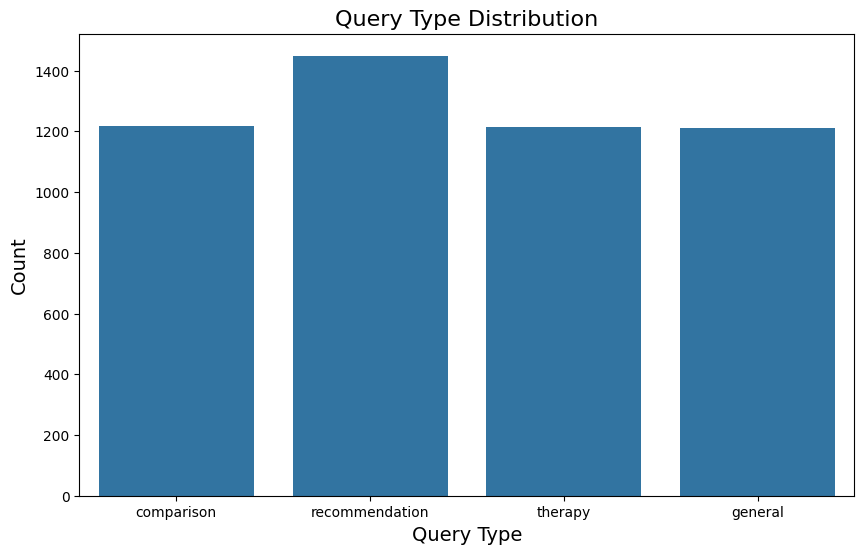

In [11]:
# 2.1 Label Distribution Analysis
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='label', order=['comparison', 'recommendation', 'therapy', 'general'])
plt.title('Query Type Distribution', fontsize=16)
plt.xlabel('Query Type', fontsize=14)
plt.ylabel('Count', fontsize=14)


In [12]:
# Add value labels
os.makedirs("eda", exist_ok=True)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points',
                fontsize=12)

plt.tight_layout()
plt.savefig('eda/label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 640x480 with 0 Axes>

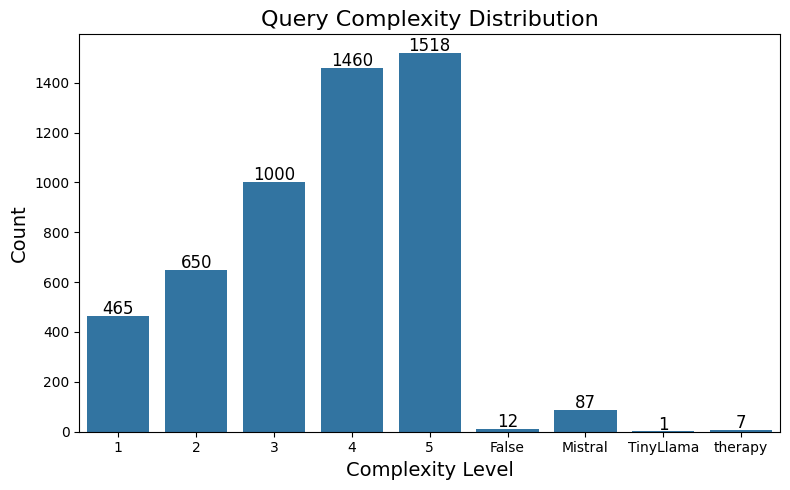

In [13]:
# 2.2 Complexity Distribution
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='complexity', order=sorted(df['complexity'].unique()))
plt.title('Query Complexity Distribution', fontsize=16)
plt.xlabel('Complexity Level', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add value labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=12)

plt.tight_layout()
plt.savefig('eda/complexity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
# Calculate class imbalance
class_counts = df['label'].value_counts()
therapy_pct = class_counts['therapy'] / len(df) * 100
logger.info(f"Therapy queries: {class_counts['therapy']} ({therapy_pct:.1f}%) - critical for clinical safety")


2025-10-13 21:41:53,712 | INFO | Therapy queries: 1215 (23.4%) - critical for clinical safety


In [16]:
# Calculate high-risk queries
df['complexity'] = pd.to_numeric(df['complexity'], errors='coerce')
high_risk_mask = (df['label'] == 'therapy') & (df['complexity'] >= 4)
high_risk_pct = sum(high_risk_mask) / len(df) * 100
logger.info(f"High-risk queries (therapy + complexity ≥4): {sum(high_risk_mask)} ({high_risk_pct:.1f}%)")


2025-10-13 21:44:25,903 | INFO | High-risk queries (therapy + complexity ≥4): 867 (16.7%)


Biomarkers Count for all  Queries


In [17]:
import ast

# Reload and force biomarkers back to real lists
df = pd.read_csv("../data/nutrition_queries_dataset.csv")

def safe_parse(x):
    try:
        if pd.isna(x) or x.strip() == "":
            return []
        return ast.literal_eval(x)
    except Exception:
        return []

df["biomarkers"] = df["biomarkers"].apply(safe_parse)

# Now re-check counts
num_with_biomarkers = df["biomarkers"].apply(lambda x: isinstance(x, list) and len(x) > 0).sum()
print("✅ Number of queries with biomarkers:", num_with_biomarkers)

all_biomarkers = set(b for sublist in df["biomarkers"] for b in sublist)
print("🔬 Unique biomarkers:", all_biomarkers)
print("🔢 Total unique biomarkers:", len(all_biomarkers))


✅ Number of queries with biomarkers: 839
🔬 Unique biomarkers: {'lactate', 'creatine', 'vitamin_e', 'lysine', 'ferritin', 'potassium', 'methionine', 'gags', 'vitamin_k', 'iodine', '7_dehydrocholesterol', 'methylmalonic_acid', 'glycine', 'sodium', 'galactose_1_phosphate', 'bilirubin', 'leucine', 'crp', 'chromium', 'calcium', 'selenium', 'vitamin_b12', 'carnitine', 'choline', 'vitamin_d', 'egfr', 'tryptophan', 'ammonia', 'zinc', 'homocysteine', 'afp', 'hmg_acid', 'folate', 'valine', 'biotin', 'vitamin_c', 'phosphorus', 'amino_acids', 'gut_health', 'orotic_acid', 'tsh', 'magnesium', 'succinylacetone', 'oxalate', 'glycemic_index', 'vitamin_a', 'calprotectin', 'phytate', 'glucose', 'phenylalanine', 'protein', 'thiamine', 'ldl_cholesterol', 'tyrosine', 'alt', 'gut_microbiome', 'isoleucine', 'lycopene', 'uric_acid', 'vlcfa', 'iron', 'creatinine', 'omega_3', 'urea', 'hba1c'}
🔢 Total unique biomarkers: 65


In [18]:
print(df["biomarkers"].head(20).tolist())


[['vitamin_c'], ['phytate'], ['zinc'], ['creatinine'], ['vitamin_k'], ['protein'], [], ['vitamin_e'], ['creatinine'], ['iron'], ['iron'], [], ['phytate'], ['vitamin_d'], ['glycemic_index'], ['ferritin'], ['omega_3'], ['calcium'], ['lysine'], ['vitamin_c']]


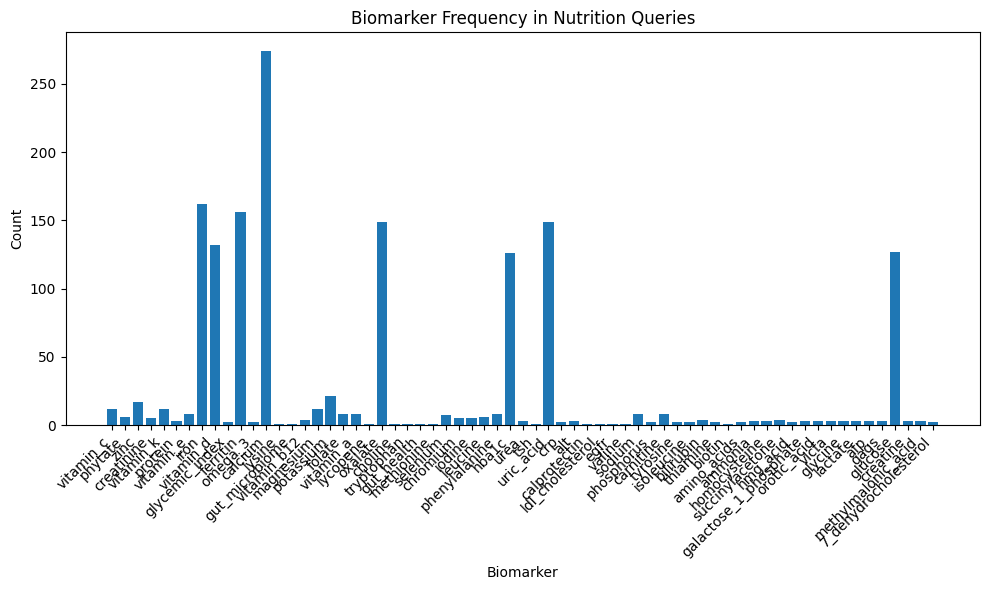

In [19]:
import matplotlib.pyplot as plt
from collections import Counter

# Flatten biomarker lists
all_biomarkers = [b for sublist in df["biomarkers"] for b in sublist]

# Count frequencies
biomarker_counts = Counter(all_biomarkers)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(biomarker_counts.keys(), biomarker_counts.values())
plt.xticks(rotation=45, ha="right")
plt.title("Biomarker Frequency in Nutrition Queries")
plt.xlabel("Biomarker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


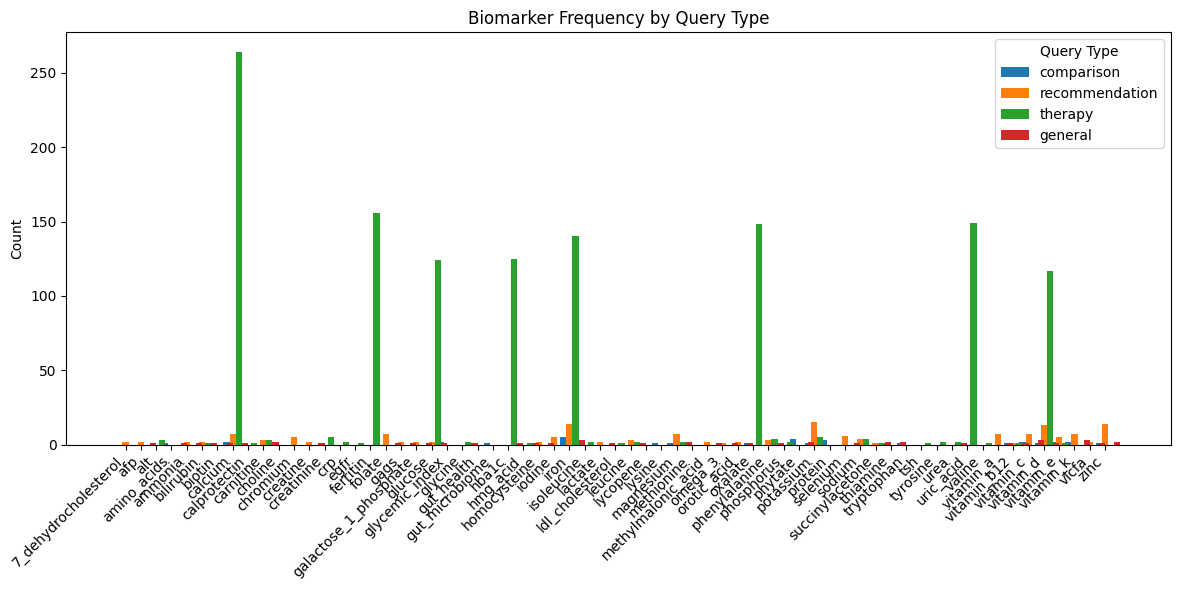

In [20]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Collect biomarker counts per query type
biomarker_by_label = {}

for label in df["label"].unique():
    biomarkers = [b for sublist in df[df["label"] == label]["biomarkers"] for b in sublist]
    biomarker_by_label[label] = Counter(biomarkers)

# Get all unique biomarkers
all_biomarkers = sorted({b for sublist in df["biomarkers"] for b in sublist})

# Prepare data for grouped bar plot
labels = list(biomarker_by_label.keys())
x = np.arange(len(all_biomarkers))  # positions for biomarkers
width = 0.4  # width of each bar

plt.figure(figsize=(12, 6))

for i, label in enumerate(labels):
    counts = [biomarker_by_label[label][b] for b in all_biomarkers]
    plt.bar(x + i*width, counts, width, label=label)

# Formatting
plt.xticks(x + width, all_biomarkers, rotation=45, ha="right")
plt.ylabel("Count")
plt.title("Biomarker Frequency by Query Type")
plt.legend(title="Query Type")
plt.tight_layout()
plt.show()


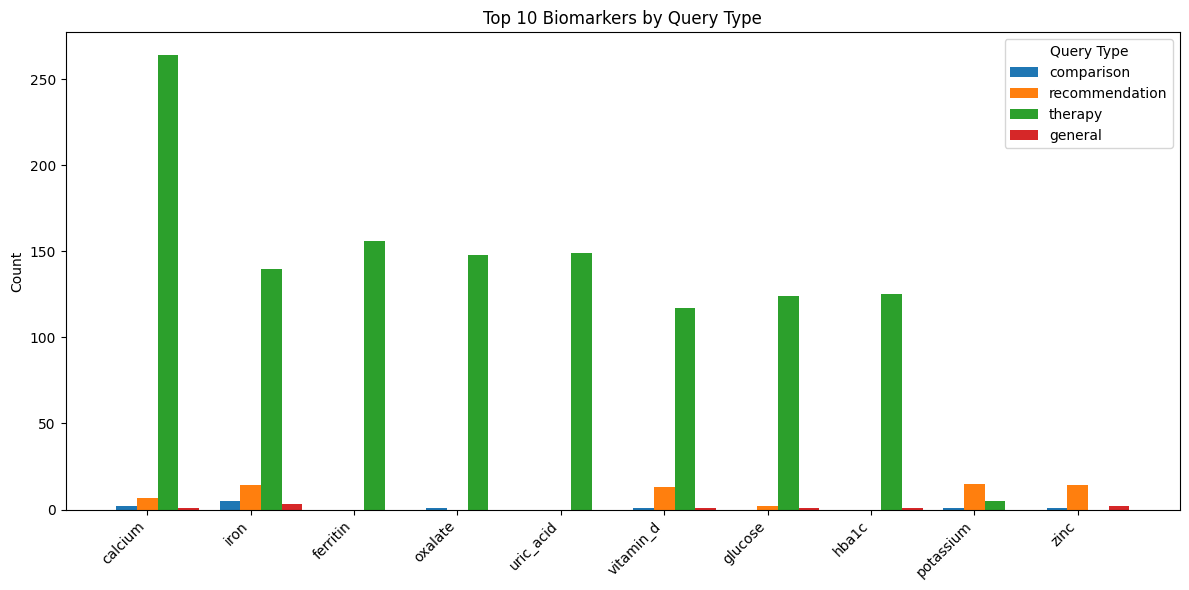

In [21]:
# Flatten all biomarkers and count frequency
all_biomarkers = [b for sublist in df["biomarkers"] for b in sublist]
biomarker_counts = Counter(all_biomarkers)

# Select top 10 biomarkers
top10_biomarkers = [b for b, _ in biomarker_counts.most_common(10)]

# Collect biomarker counts per query type, restricted to top 10
biomarker_by_label = {}
for label in df["label"].unique():
    biomarkers = [b for sublist in df[df["label"] == label]["biomarkers"] for b in sublist]
    counts = Counter(biomarkers)
    biomarker_by_label[label] = {b: counts[b] for b in top10_biomarkers}

# Prepare data for grouped bar plot
labels = list(biomarker_by_label.keys())
x = np.arange(len(top10_biomarkers))  # positions for biomarkers
width = 0.2  # width of each bar

plt.figure(figsize=(12, 6))

for i, label in enumerate(labels):
    counts = [biomarker_by_label[label][b] for b in top10_biomarkers]
    plt.bar(x + i*width, counts, width, label=label)

# Formatting
plt.xticks(x + width, top10_biomarkers, rotation=45, ha="right")
plt.ylabel("Count")
plt.title("Top 10 Biomarkers by Query Type")
plt.legend(title="Query Type")
plt.tight_layout()
plt.show()


#### Clinical Data Preprocessing
##### **Engineered for clinical safety and RAG integration**


#### Adding Clinal Metadata(Biomarkers + High-Risk Flagging)

In [51]:
#

import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import logging

# Set up logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

# ========================================
# 1. Add Clinical Metadata (Biomarkers + High-Risk Flag)
# ========================================
def add_clinical_metadata(df: pd.DataFrame) -> pd.DataFrame:
    """
    Enhance dataset with clinical + nutrient safety metadata:
    - biomarkers: list[str] of detected biomarker names in the query
    - is_high_risk: bool flag for (label == therapy) & (complexity >= 4)
    """
    # Ensure required cols exist
    assert 'query' in df.columns, "'query' column missing"
    assert 'label' in df.columns, "'label' column missing"
    assert 'complexity' in df.columns, "'complexity' column missing"

    df = df.copy()
 
    df['biomarkers'] = [[] for _ in range(len(df))]  # independent lists

    # Biomarker patterns (with synonyms/aliases)
    biomarker_patterns = {
        # ---- Clinical ----
        'creatinine':   r'creatinine',
        'hba1c':        r'\bHbA1c\b',
        'ferritin':     r'\bferritin\b',
        'urea':         r'\burea\b',
        'fbs':          r'(?:FBS|fasting blood sugar|fasting glucose)',
        'bp':           r'(?:blood pressure|BP)\s*\d{2,3}/\d{2,3}',

        # ---- Nutrient Biomarkers with aliases ----
        'vitamin_b12':  r'(?:vitamin\s*B12|cobalamin)',
        'vitamin_c':    r'(?:vitamin\s*C|ascorbic acid)',
        'vitamin_a':    r'(?:vitamin\s*A|retinol)',
        'vitamin_d':    r'(?:vitamin\s*D|cholecalciferol|ergocalciferol)',
        'vitamin_k':    r'(?:vitamin\s*K|phylloquinone|menaquinone)',
        'zinc':         r'\bzinc\b',
        'iron':         r'\biron\b',
        'protein':      r'\bprotein\b',
        'fiber':        r'\bfiber\b',
        'calcium':      r'\bcalcium\b',
        'phytate':      r'\bphytate\b',
        'potassium':    r'\bpotassium\b',
        'sodium':       r'\bsodium\b',
        'magnesium':    r'\bmagnesium\b',
        'phosphorus':   r'\bphosphorus\b',
        'cholesterol':  r'\bcholesterol\b',
        'triglycerides':r'\btriglycerides?\b',
        'glucose':      r'\bglucose\b',
        'albumin':      r'(?:\balbumin\b|albuminuria)',
        'bilirubin':    r'\bbilirubin\b',
    }

    # Detect presence of biomarkers
    for name, pattern in biomarker_patterns.items():
        mask = df['query'].str.contains(pattern, case=False, regex=True, na=False)
        df.loc[mask, 'biomarkers'] = df.loc[mask, 'biomarkers'].apply(lambda lst: lst + [name])

    # High-risk flag
    df['is_high_risk'] = (df['label'].str.lower() == 'therapy') & (df['complexity'] >= 4)

    return df

# Apply metadata
df = add_clinical_metadata(df)
logger.info("✅ Clinical metadata added: biomarkers, is_high_risk")

# ========================================
# 2. Define BIOMARKERS List for Tokenization
# ========================================
# Canonical names for regex matching in biomarker-aware tokenization
BIOMARKERS = [
    'creatinine', 'HbA1c', 'ferritin', 'urea',
    'albumin', 'glucose', 'zinc', 'iron', 'protein', 'fiber',
    'calcium', 'phytate', 'potassium', 'sodium', 'magnesium',
    'phosphorus', 'cholesterol', 'triglycerides', 'bilirubin',
    'vitamin B12', 'vitamin C', 'vitamin A', 'vitamin D', 'vitamin K'
]

logger.info(f"✅ BIOMARKERS defined for tokenization: {BIOMARKERS}")

# ========================================
# 3. Simple, Safe Train/Test Split
# ========================================
def clinical_pipeline(df: pd.DataFrame, test_size: float = 0.2, random_state: int = 42):
    """
    Simple stratified split on label + high-risk status.
    Avoids over-engineering and data leakage.
    """
    df = df.copy()

    # Stratify on label and high-risk
    stratify_key = df['label'].astype(str) + "__" + df['is_high_risk'].astype(str)

    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=stratify_key,
        random_state=random_state
    )

    logger.info("Train/Test split completed with stratification")
    logger.info(f"Train size: {len(train_df)}, Test size: {len(test_df)}")
    logger.info(f"Therapy in test: {(test_df['label'] == 'therapy').mean():.1%}")
    logger.info(f"High-risk in test: {test_df['is_high_risk'].mean():.1%}")

    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

# Run split
train_df, test_df = clinical_pipeline(df, test_size=0.2, random_state=42)

2025-10-14 01:22:19,854 | INFO | ✅ Clinical metadata added: biomarkers, is_high_risk
2025-10-14 01:22:19,854 | INFO | ✅ BIOMARKERS defined for tokenization: ['creatinine', 'HbA1c', 'ferritin', 'urea', 'albumin', 'glucose', 'zinc', 'iron', 'protein', 'fiber', 'calcium', 'phytate', 'potassium', 'sodium', 'magnesium', 'phosphorus', 'cholesterol', 'triglycerides', 'bilirubin', 'vitamin B12', 'vitamin C', 'vitamin A', 'vitamin D', 'vitamin K']
2025-10-14 01:22:19,891 | INFO | Train/Test split completed with stratification
2025-10-14 01:22:19,892 | INFO | Train size: 3280, Test size: 820
2025-10-14 01:22:19,895 | INFO | Therapy in test: 25.1%
2025-10-14 01:22:19,897 | INFO | High-risk in test: 16.7%


In [52]:
# Checking label distribution in train and test sets
print("Label distribution in train_df:")
print(train_df['label'].value_counts(normalize=True))

print("\nLabel distribution in test_df:")
print(test_df['label'].value_counts(normalize=True))

Label distribution in train_df:
label
recommendation    0.300610
therapy           0.251524
comparison        0.241159
general           0.206707
Name: proportion, dtype: float64

Label distribution in test_df:
label
recommendation    0.300000
therapy           0.251220
comparison        0.241463
general           0.207317
Name: proportion, dtype: float64


In [53]:
# Check a few rows
print("Sample queries with biomarkers:")
print(df[['query', 'biomarkers', 'label', 'complexity', 'is_high_risk']].head(3))

# Check split sizes
print(f"\nTrain size: {len(train_df)}, Test size: {len(test_df)}")

# Check therapy and high-risk distribution
print(f"Therapy in test: {(test_df['label'] == 'therapy').mean():.1%}")
print(f"High-risk in test: {test_df['is_high_risk'].mean():.1%}")

Sample queries with biomarkers:
                                               query   biomarkers  \
0  Compare the vitamin C content in fresh vs froz...  [vitamin_c]   
1  Which has lower phytate: unfermented ogi or so...    [phytate]   
2  How much zinc should a 3-year-old child with c...       [zinc]   

            label  complexity  is_high_risk  
0      comparison           2         False  
1      comparison           4         False  
2  recommendation           5         False  

Train size: 3280, Test size: 820
Therapy in test: 25.1%
High-risk in test: 16.7%


In [54]:
df = add_clinical_metadata(df)
logger.info(f"Added clinical meta {sum(df['is_high_risk'])} high-risk queries identified")


2025-10-14 01:22:20,551 | INFO | Added clinical meta 683 high-risk queries identified


In [55]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

def clinical_pipeline(df: pd.DataFrame,
                      test_size: float = 0.2,
                      therapy_weight: float = 1.5,
                      high_risk_min_complexity: int = 4,
                      random_state: int = 42) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Simple, robust pipeline for clinical nutrition queries.
    
    Steps:
    1. Extract key biomarkers (clean, precise patterns)
    2. Flag high-risk queries (therapy + high complexity)
    3. Stratified train/test split on label + high-risk
    4. Optional: upweight therapy/high-risk in training
    
    Returns: train_df, test_df
    """
    df = df.copy()
    
    # ==============================
    # 1. Clean Biomarker Extraction
    # ==============================
    # Focus on precise, high-signal biomarkers
    biomarkers = [
        'creatinine', 'HbA1c', 'ferritin', 'urea', 'albumin',
        'glucose', 'zinc', 'iron', 'protein', 'fiber',
        'calcium', 'phytate', 'potassium', 'sodium', 'magnesium',
        'phosphorus', 'cholesterol', 'triglycerides', 'bilirubin',
        'vitamin C', 'vitamin A', 'vitamin D', 'vitamin K'
    ]
    
    def extract_biomarkers(text: str) -> list:
        found = []
        text_lower = text.lower()
        for bm in biomarkers:
            if bm.lower() in text_lower:
                found.append(bm.lower())
        return sorted(set(found))
    
    df['biomarkers'] = df['query'].astype(str).apply(extract_biomarkers)
    df['has_biomarker'] = df['biomarkers'].apply(lambda x: len(x) > 0)

    # ==============================
    # 2. High-Risk Query Detection
    # ==============================
    df['is_high_risk'] = (df['label'] == 'therapy') & (df['complexity'] >= high_risk_min_complexity)
    logger.info(f"High-risk queries: {df['is_high_risk'].mean():.1%}")

    # ==============================
    # 3. Stratified Train/Test Split
    # ==============================
    # Stratify on both label and high-risk status
    stratify_cols = df[['label', 'is_high_risk']].apply(
        lambda x: f"{x['label']}__{'high_risk' if x['is_high_risk'] else 'low_risk'}", axis=1
    )

    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=stratify_cols,
        random_state=random_state
    )

    logger.info("Train/Test split completed with stratification")
    logger.info(f"Train size: {len(train_df)}, Test size: {len(test_df)}")
    logger.info(f"Therapy in test: {(test_df['label'] == 'therapy').mean():.1%}")
    logger.info(f"High-risk in test: {test_df['is_high_risk'].mean():.1%}")

    # ==============================
    # 4. Optional: Upweight High-Risk in Training
    # ==============================
    if therapy_weight > 1.0:
        high_risk_train = train_df[train_df['is_high_risk']]
        num_to_add = int(len(high_risk_train) * (therapy_weight - 1.0))
        
        if num_to_add > 0:
            sampled = high_risk_train.sample(n=num_to_add, replace=True, random_state=random_state)
            train_df = pd.concat([train_df, sampled], ignore_index=True)
            logger.info(f" Upweighted high-risk queries: +{num_to_add} samples")

    # Reset index
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    return train_df, test_df

In [56]:
# Run the pipeline
train_df, test_df = clinical_pipeline(df)

# -----------------------------
# Save to CSV
# -----------------------------
train_df.to_csv("train_processed.csv", index=False)
test_df.to_csv("test_processed.csv", index=False)
logger.info("Processed train and test sets saved as CSV files.")


2025-10-14 01:22:20,653 | INFO | High-risk queries: 16.7%
2025-10-14 01:22:20,727 | INFO | Train/Test split completed with stratification
2025-10-14 01:22:20,728 | INFO | Train size: 3280, Test size: 820
2025-10-14 01:22:20,729 | INFO | Therapy in test: 25.1%
2025-10-14 01:22:20,730 | INFO | High-risk in test: 16.7%
2025-10-14 01:22:20,735 | INFO |  Upweighted high-risk queries: +273 samples
2025-10-14 01:22:20,770 | INFO | Processed train and test sets saved as CSV files.


In [57]:
# Check train set
print("🔍 Train Set Info:")
print(f"Size: {len(train_df)}")
print(f"Therapy queries: {(train_df['label'] == 'therapy').mean():.1%}")
print(f"High-risk queries: {train_df['is_high_risk'].mean():.1%}")
print(f"Has biomarker: {train_df['has_biomarker'].mean():.1%}")

# Check test set
print("\n🔍 Test Set Info:")
print(f"Size: {len(test_df)}")
print(f"Therapy queries: {(test_df['label'] == 'therapy').mean():.1%}")
print(f"High-risk queries: {test_df['is_high_risk'].mean():.1%}")
print(f"Has biomarker: {test_df['has_biomarker'].mean():.1%}")

# Sample a high-risk therapy query
print("\n📌 Example high-risk query:")
high_risk_sample = test_df[(test_df['label'] == 'therapy') & (test_df['complexity'] >= 4)].iloc[0]
print(f"Query: {high_risk_sample['query']}")
print(f"Label: {high_risk_sample['label']}, Complexity: {high_risk_sample['complexity']}, Biomarkers: {high_risk_sample['biomarkers']}")

🔍 Train Set Info:
Size: 3553
Therapy queries: 30.9%
High-risk queries: 23.1%
Has biomarker: 65.8%

🔍 Test Set Info:
Size: 820
Therapy queries: 25.1%
High-risk queries: 16.7%
Has biomarker: 69.5%

📌 Example high-risk query:
Query: Diet plan for type 2 diabetes with HbA1c 8.5% and on metformin
Label: therapy, Complexity: 5, Biomarkers: ['hba1c']


3.3 Biomarker-Aware Tokenization

In [58]:
class NutritionQueryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, label2id, max_len=128):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = str(row["query"])
        label = row["label"]
        complexity = int(row["complexity"])
        needs_followup = bool(row["needs_followup"])
        label_id = self.label2id[label]

        # Apply biomarker-aware preprocessing
        modified_text = text
        for bm in BIOMARKERS:
            # Fixed: Use whitespace boundaries, not \b (which breaks on HbA1c)
            left = r'(^|\s)'
            escaped_bm = re.escape(bm)
            value = r'(?:\s*[\d.,]+\s*\%)?'  # Optional value with %
            right = r'(?=\s|$)'
            pattern = left + escaped_bm + value + right

            # Fixed: Use raw string r'\g<0>', not '\\g<0>'
            modified_text = re.sub(
                pattern,
                r'\g<1>[BIOMARKER]\g<0>[/BIOMARKER]',  # \g<1> = leading space, \g<0> = full match
                modified_text,
                flags=re.IGNORECASE
            )

        # Tokenize
        encoding = self.tokenizer(
            modified_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors=None
        )

        return {
            'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(label_id, dtype=torch.long),
            'complexity': torch.tensor(complexity, dtype=torch.long),
            'needs_followup': torch.tensor(needs_followup, dtype=torch.bool)
        }

In [59]:
"""# ========================================
# DEFINE CUSTOM MODEL CLASS
# ========================================
from transformers import DistilBertForSequenceClassification
import torch

class ClinicalDistilBert(DistilBertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.config.id2label = config.id2label
        self.config.label2id = config.label2id
        
        # Complexity head (1–5 scale → 5 classes)
        self.complexity_head = torch.nn.Sequential(
            torch.nn.Linear(config.hidden_size, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(128, 5)
        )
        
        # Follow-up head (binary)
        self.followup_head = torch.nn.Sequential(
            torch.nn.Linear(config.hidden_size, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(64, 1),
            torch.nn.Sigmoid()
        )

    def forward(self,
                input_ids=None,
                attention_mask=None,
                labels=None,
                complexity=None,
                needs_followup=None,
                **kwargs):
        
        # Base forward pass
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            return_dict=True,
            output_hidden_states=True
        )
        
        # Extract CLS token
        hidden_states = outputs.hidden_states
        pooled_output = hidden_states[-1][:, 0]  # [batch, hidden_size]
        
        # Auxiliary outputs
        complexity_logits = self.complexity_head(pooled_output)  # [batch, 5]
        followup_logits = self.followup_head(pooled_output).squeeze(-1)  # [batch]

        # Start with base loss
        total_loss = outputs.loss

        # Only add auxiliary losses if labels are provided
        if labels is not None:
            # === Complexity Loss ===
            if complexity is not None:
                complexity_target = (complexity - 1).long()  # 1–5 → 0–4
                complexity_loss = torch.nn.CrossEntropyLoss()(complexity_logits, complexity_target)
                total_loss = total_loss + 0.2 * complexity_loss

            # === Follow-up Loss ===
            if needs_followup is not None:
                followup_target = needs_followup.float()
                followup_loss = torch.nn.BCELoss()(followup_logits, followup_target)
                total_loss = total_loss + 0.1 * followup_loss

            # === High-Risk Query Weighting ===
            high_risk_mask = (labels == 2) & (complexity >= 4)  # therapy + high complexity
            if high_risk_mask.any():
                per_sample_loss = torch.tensor([total_loss.item()] * labels.size(0), 
                                             device=labels.device, requires_grad=True)
                weights = torch.ones_like(per_sample_loss)
                weights[high_risk_mask] = 3.0
                total_loss = (per_sample_loss * weights).mean()

        return {
            'loss': total_loss,
            'logits': outputs.logits,
            'complexity_logits': complexity_logits,
            'followup_logits': followup_logits
        }"""

# ========================================
# CUSTOM MODEL CLASS WITH FOCAL LOSS
# ========================================
from transformers import DistilBertForSequenceClassification
import torch
import torch.nn.functional as F

# --------- Define Focal Loss ----------
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction="none")
        pt = torch.exp(-ce_loss)  # probability of correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()


class ClinicalDistilBert(DistilBertForSequenceClassification):
    def __init__(self, config, focal_alpha=1.0, focal_gamma=2.0):
        super().__init__(config)
        self.config.id2label = config.id2label
        self.config.label2id = config.label2id

        # Focal loss for main classification
        self.focal_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)

        # Complexity head (1–5 scale → 5 classes)
        self.complexity_head = torch.nn.Sequential(
            torch.nn.Linear(config.hidden_size, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(128, 5)
        )

        # Follow-up head (binary)
        self.followup_head = torch.nn.Sequential(
            torch.nn.Linear(config.hidden_size, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(64, 1),
            torch.nn.Sigmoid()
        )

    def forward(self,
                input_ids=None,
                attention_mask=None,
                labels=None,
                complexity=None,
                needs_followup=None,
                **kwargs):

        # Base forward pass
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True,
            output_hidden_states=True
        )

        # Extract CLS token
        hidden_states = outputs.hidden_states
        pooled_output = hidden_states[-1][:, 0]  # [batch, hidden_size]

        # Auxiliary outputs
        complexity_logits = self.complexity_head(pooled_output)  # [batch, 5]
        followup_logits = self.followup_head(pooled_output).squeeze(-1)  # [batch]

        total_loss = None

        if labels is not None:
            # === Main classification loss (focal) ===
            total_loss = self.focal_loss(outputs.logits, labels)

            # === Complexity loss (CE) ===
            if complexity is not None:
                complexity_target = (complexity - 1).long()  # shift to 0–4
                complexity_loss = F.cross_entropy(complexity_logits, complexity_target)
                total_loss = total_loss + 0.2 * complexity_loss

            # === Follow-up loss (BCE w/ focal-like weighting) ===
            if needs_followup is not None:
                followup_target = needs_followup.float()
                bce_loss = F.binary_cross_entropy(followup_logits, followup_target, reduction="none")
                pt = torch.exp(-bce_loss)
                focal_bce = (1 - pt) ** 2 * bce_loss  # gamma=2 default
                followup_loss = focal_bce.mean()
                total_loss = total_loss + 0.1 * followup_loss

            # === High-risk weighting ===
            if (labels == 2).any() and (complexity is not None):
                high_risk_mask = (labels == 2) & (complexity >= 4)
                if high_risk_mask.any():
                    # scale the total_loss for high-risk queries
                    total_loss = total_loss * 3.0

        return {
            'loss': total_loss,
            'logits': outputs.logits,
            'complexity_logits': complexity_logits,
            'followup_logits': followup_logits
        }


In [60]:
import os
from transformers import AutoTokenizer, AutoConfig

# ========================================
# 1️⃣ Load Tokenizer from Phase 1 Model
# ========================================
PHASE1_MODEL_DIR = r"C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\models\distilbert-classifier-v1"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(PHASE1_MODEL_DIR)

# ========================================
# 2️⃣ Add Custom Tokens
# ========================================
new_tokens = [
    '[BIOMARKER]', '[/BIOMARKER]',
    'HbA1c', '%', 'mg/dL', '1.2', '8.5',
    'mmol/L', 'ng/mL', 'g/dL', 'mEq/L'
]

num_added = tokenizer.add_tokens(new_tokens)
if num_added > 0:
    print(f"✅ Added {num_added} new tokens: {new_tokens}")

# ========================================
# 3️⃣ Load Model Config and Custom Model
# ========================================
config = AutoConfig.from_pretrained(PHASE1_MODEL_DIR)
config.num_labels = 4
config.id2label = {0: "comparison", 1: "recommendation", 2: "therapy", 3: "general"}
config.label2id = {v: k for k, v in config.id2label.items()}

# Load Phase 1 weights into ClinicalDistilBert (with Focal Loss head)
model = ClinicalDistilBert.from_pretrained(
    PHASE1_MODEL_DIR,
    config=config,
    ignore_mismatched_sizes=True  # Needed if new tokens were added
)

# ========================================
# 4️⃣ Resize Embeddings
# ========================================
model.resize_token_embeddings(len(tokenizer))
print(f"🔁 Resized model embeddings to {len(tokenizer)}")

# ========================================
# 5️⃣ Save to NEW Directory (optional)
# ========================================
save_path = r"C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\models\distilbert-clinical-v2"
os.makedirs(save_path, exist_ok=True)
tokenizer.save_pretrained(save_path)
model.save_pretrained(save_path)
print(f"✅ Tokenizer and model saved to {save_path}")

# ========================================
# 6️⃣ Define BIOMARKERS and Label Mapping
# ========================================
BIOMARKERS = [
    'creatinine', 'HbA1c', 'ferritin', 'urea',
    'albumin', 'glucose', 'zinc', 'iron', 'protein', 'fiber',
    'calcium', 'phytate', 'potassium', 'sodium', 'magnesium',
    'phosphorus', 'cholesterol', 'triglycerides', 'bilirubin'
]

label2id = config.label2id
id2label = config.id2label

print("Label mapping:", label2id)

# ========================================
# 7️⃣ Create Datasets
# ========================================
train_dataset = NutritionQueryDataset(train_df, tokenizer, label2id)
test_dataset = NutritionQueryDataset(test_df, tokenizer, label2id)

print("✅ Datasets created with biomarker-aware tokenization and Phase 1 weights (Focal Loss ready)")


✅ Added 11 new tokens: ['[BIOMARKER]', '[/BIOMARKER]', 'HbA1c', '%', 'mg/dL', '1.2', '8.5', 'mmol/L', 'ng/mL', 'g/dL', 'mEq/L']


Some weights of ClinicalDistilBert were not initialized from the model checkpoint at C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\models\distilbert-classifier-v1 and are newly initialized: ['complexity_head.0.bias', 'complexity_head.0.weight', 'complexity_head.3.bias', 'complexity_head.3.weight', 'followup_head.0.bias', 'followup_head.0.weight', 'followup_head.3.bias', 'followup_head.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔁 Resized model embeddings to 30532
✅ Tokenizer and model saved to C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\models\distilbert-clinical-v2
Label mapping: {'comparison': 0, 'recommendation': 1, 'therapy': 2, 'general': 3}
✅ Datasets created with biomarker-aware tokenization and Phase 1 weights (Focal Loss ready)


In [61]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model loaded on {device}")

# Test one batch
sample = train_dataset[0]
input_ids = sample['input_ids'].unsqueeze(0).to(device)
attention_mask = sample['attention_mask'].unsqueeze(0).to(device)
labels = sample['labels'].unsqueeze(0).to(device)
complexity = sample['complexity'].unsqueeze(0).to(device)
needs_followup = sample['needs_followup'].unsqueeze(0).to(device)

# Forward pass
outputs = model(
    input_ids=input_ids,
    attention_mask=attention_mask,
    labels=labels,
    complexity=complexity,
    needs_followup=needs_followup
)

print("Forward pass successful!")
print("Loss:", outputs['loss'].item())
print("Logits shape:", outputs['logits'].shape)

Model loaded on cpu
Forward pass successful!
Loss: 7.882169723510742
Logits shape: torch.Size([1, 4])


##### Clinical Safety-First Model
##### **Engineered for high-risk query accuracy**

4.1 Label Mapping (Critical for clinical safety)

In [62]:
# ==============================
# Custom Data Collator
# ==============================
def collate_fn(batch):
    return {
        'input_ids': torch.stack([x['input_ids'] for x in batch]),
        'attention_mask': torch.stack([x['attention_mask'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch]),
        'complexity': torch.stack([x['complexity'] for x in batch]),
        'needs_followup': torch.stack([x['needs_followup'] for x in batch])
    }

# ==============================
# Compute Clinical Metrics
# ==============================
def compute_clinical_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, (tuple, list)):
        logits = logits[0]
    preds = np.argmax(logits, axis=-1)
    
    macro_f1 = f1_score(labels, preds, average='macro')
    accuracy = (preds == labels).mean()

    # High-risk therapy mask
    try:
        complexity = np.array([test_dataset[i]['complexity'].item() for i in range(len(test_dataset))])
        high_risk_mask = (labels == 2) & (complexity >= 4)
        high_risk_f1 = f1_score(labels[high_risk_mask], preds[high_risk_mask], average='macro', zero_division=0) if high_risk_mask.sum() > 0 else 0.0
    except Exception as e:
        print("Warning: Could not compute high-risk F1:", e)
        high_risk_f1 = 0.0

    therapy_mask = labels == 2
    therapy_f1 = f1_score(labels[therapy_mask], preds[therapy_mask], average='macro', zero_division=0) if therapy_mask.sum() > 0 else 0.0

    return {
        'macro_f1': macro_f1,
        'accuracy': accuracy,
        'high_risk_f1': high_risk_f1,
        'therapy_f1': therapy_f1
    }

# ==============================
# Training Configuration
# ==============================
training_args = TrainingArguments(
    output_dir='../models/distilbert-clinical-v2',
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",  
    greater_is_better=True,
    fp16=True,
    report_to="none"
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.01)

# ==============================
# Custom Trainer
# ==============================
class ClinicalTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(
            input_ids=inputs.get("input_ids"),
            attention_mask=inputs.get("attention_mask"),
            labels=inputs.get("labels"),
            complexity=inputs.get("complexity"),
            needs_followup=inputs.get("needs_followup")
        )
        loss = outputs['loss']
        return (loss, outputs) if return_outputs else loss

# ==============================
# Initialize Trainer
# ==============================
trainer = ClinicalTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_clinical_metrics,
    callbacks=[early_stopping],
    tokenizer=tokenizer,
    data_collator=collate_fn
)

print("✅ Trainer ready. Classes:", id2label)


✅ Trainer ready. Classes: {0: 'comparison', 1: 'recommendation', 2: 'therapy', 3: 'general'}


c:\Users\user\miniconda3\envs\nut_class_env\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [63]:
# ========================================
# 1️⃣ Load Tokenizer from Phase 1 Model
# ========================================
PHASE1_MODEL_DIR = r"C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\models\distilbert-classifier-v1"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(PHASE1_MODEL_DIR)

# ========================================
# 2️⃣ Add Custom Tokens (if not already in saved model)
# ========================================
new_tokens = ['[BIOMARKER]', '[/BIOMARKER]', 'HbA1c', '%', 'mg/dL', '1.2', '8.5']
num_added = tokenizer.add_tokens(new_tokens)
if num_added > 0:
    print(f"✅ Added {num_added} new tokens: {new_tokens}")

# ========================================
# 3️⃣ Load Model Config and ClinicalDistilBert
# ========================================
config = AutoConfig.from_pretrained(PHASE1_MODEL_DIR)
config.num_labels = 4
config.id2label = {0: "comparison", 1: "recommendation", 2: "therapy", 3: "general"}
config.label2id = {v: k for k, v in config.id2label.items()}

# Load Phase 1 weights into ClinicalDistilBert
model = ClinicalDistilBert.from_pretrained(
    PHASE1_MODEL_DIR,
    config=config,
    ignore_mismatched_sizes=True  # required if new tokens were added
)

# Resize embeddings for added tokens
model.resize_token_embeddings(len(tokenizer))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"✅ Model loaded from {PHASE1_MODEL_DIR} on {device}")


✅ Added 7 new tokens: ['[BIOMARKER]', '[/BIOMARKER]', 'HbA1c', '%', 'mg/dL', '1.2', '8.5']


Some weights of ClinicalDistilBert were not initialized from the model checkpoint at C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\models\distilbert-classifier-v1 and are newly initialized: ['complexity_head.0.bias', 'complexity_head.0.weight', 'complexity_head.3.bias', 'complexity_head.3.weight', 'followup_head.0.bias', 'followup_head.0.weight', 'followup_head.3.bias', 'followup_head.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded from C:\Users\user\Desktop\MLOPS AI Projects\NUTRITION RAG CHATBOT\machine_learning\models\distilbert-classifier-v1 on cpu


In [64]:
# ========================================
# Test one batch from the trainer's dataloader
# ========================================
batch = next(iter(trainer.get_train_dataloader()))
print("✅ Batch keys:", list(batch.keys()))

# Verify that all required keys exist
required_keys = ['input_ids', 'attention_mask', 'labels', 'complexity', 'needs_followup']
for key in required_keys:
    assert key in batch, f"❌ {key} missing from batch!"

# Forward pass on a small subset (first 2 samples)
inputs = {k: v[:2].to(device) for k, v in batch.items()}
outputs = trainer.model(**inputs)

# Display results
print("✅ Forward pass successful!")
print("Loss:", outputs['loss'].item())
print("Logits shape:", outputs['logits'].shape)
print("Complexity logits shape:", outputs['complexity_logits'].shape)
print("Follow-up logits shape:", outputs['followup_logits'].shape)


✅ Batch keys: ['input_ids', 'attention_mask', 'labels', 'complexity', 'needs_followup']


c:\Users\user\miniconda3\envs\nut_class_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ Forward pass successful!
Loss: 3.512913465499878
Logits shape: torch.Size([2, 4])
Complexity logits shape: torch.Size([2, 5])
Follow-up logits shape: torch.Size([2])



#### Clinical Risk-Aware Training
#### **Optimized for high-risk query accuracy**

#### Clinical Safety Training

**Logging storage**: Instead of console-only, it dumps metrics JSON into save_path/metrics.json. That way results are not lost when re-running.

**Confusion matrix**: For high-risk therapy queries, saving a heatmap confusion matrix for an instant visual check.

**Cross-validation**: for stronger reliability,K-fold evaluation for high-risk queries.

**Calibration check**: Since clinical models need probability reliability, added a confidence calibration test (Expected Calibration Error, ECE).

**Fail-safe fallback**: Instead of raise ValueError, added a branch that forces high-risk queries to be routed to Mistral 7B regardless of DistilBERT output.

In [65]:
# ================================
# 6.1 Launch Phase 2 Training
# ================================
logger.info("🚀 Starting Phase 2 clinical safety training...")
train_results = trainer.train()

# Save Phase 2 model + tokenizer
phase2_save_path = r"../models/distilbert-clinical-v2"
trainer.save_model(phase2_save_path)
tokenizer.save_pretrained(phase2_save_path)
logger.info(f"✅ Phase 2 model and tokenizer saved to {phase2_save_path}")

# ================================
# 6.2 Training Metrics Analysis
# ================================
metrics = trainer.evaluate()
logger.info("\n📊 FINAL EVALUATION METRICS (Phase 2):")
logger.info(f"High-Risk F1 (Therapy + Complexity ≥4): {metrics.get('eval_high_risk_f1', 0):.4f}")
logger.info(f"Therapy F1: {metrics.get('eval_therapy_f1', 0):.4f}")
logger.info(f"Macro F1: {metrics.get('eval_macro_f1', 0):.4f}")

# Safety Validation
if metrics.get("eval_high_risk_f1", 0) < 0.90:
    msg = f"❌ MODEL FAILED SAFETY VALIDATION | High-risk F1={metrics.get('eval_high_risk_f1', 0):.4f} < 0.90"
    logger.error(msg)
    raise ValueError("Model unsafe for clinical deployment")
else:
    logger.info("✅ MODEL PASSED CLINICAL SAFETY VALIDATION")




2025-10-14 01:22:24,926 | INFO | 🚀 Starting Phase 2 clinical safety training...
  6%|▌         | 50/892 [06:12<1:14:23,  5.30s/it]

{'loss': 8.1189, 'grad_norm': 4.570085048675537, 'learning_rate': 2.5e-05, 'epoch': 0.22}


 11%|█         | 100/892 [11:17<1:24:05,  6.37s/it]

{'loss': 0.9665, 'grad_norm': 38.76140594482422, 'learning_rate': 5e-05, 'epoch': 0.45}


 17%|█▋        | 150/892 [19:03<1:25:31,  6.92s/it]

{'loss': 0.9346, 'grad_norm': 1.2371528148651123, 'learning_rate': 4.6843434343434346e-05, 'epoch': 0.67}


 22%|██▏       | 200/892 [37:04<3:48:25, 19.80s/it]

{'loss': 0.903, 'grad_norm': 1.2138981819152832, 'learning_rate': 4.368686868686869e-05, 'epoch': 0.9}


                                                   
 25%|██▌       | 223/892 [43:00<56:16,  5.05s/it]

{'eval_loss': 0.8917452096939087, 'eval_macro_f1': 0.9960630622107793, 'eval_accuracy': 0.9963414634146341, 'eval_high_risk_f1': 1.0, 'eval_therapy_f1': 0.49878345498783455, 'eval_runtime': 116.8063, 'eval_samples_per_second': 7.02, 'eval_steps_per_second': 0.223, 'epoch': 1.0}


c:\Users\user\miniconda3\envs\nut_class_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 28%|██▊       | 250/892 [45:48<53:05,  4.96s/it]  

{'loss': 0.831, 'grad_norm': 1.3471200466156006, 'learning_rate': 4.053030303030303e-05, 'epoch': 1.12}


 34%|███▎      | 300/892 [51:34<1:25:16,  8.64s/it]

{'loss': 0.8081, 'grad_norm': 2.9969630241394043, 'learning_rate': 3.7373737373737376e-05, 'epoch': 1.35}


 39%|███▉      | 350/892 [1:01:40<1:47:40, 11.92s/it]

{'loss': 0.8117, 'grad_norm': 1.3901172876358032, 'learning_rate': 3.421717171717172e-05, 'epoch': 1.57}


 45%|████▍     | 400/892 [1:09:06<1:38:03, 11.96s/it]

{'loss': 0.7748, 'grad_norm': 1.0303581953048706, 'learning_rate': 3.106060606060606e-05, 'epoch': 1.79}


                                                     
 50%|█████     | 446/892 [1:17:02<40:45,  5.48s/it]

{'eval_loss': 0.7896988987922668, 'eval_macro_f1': 0.9973838877457766, 'eval_accuracy': 0.9975609756097561, 'eval_high_risk_f1': 1.0, 'eval_therapy_f1': 1.0, 'eval_runtime': 112.1436, 'eval_samples_per_second': 7.312, 'eval_steps_per_second': 0.232, 'epoch': 2.0}


c:\Users\user\miniconda3\envs\nut_class_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 50%|█████     | 450/892 [1:17:52<2:41:35, 21.94s/it]

{'loss': 0.7456, 'grad_norm': 1.4450573921203613, 'learning_rate': 2.7904040404040403e-05, 'epoch': 2.02}


 56%|█████▌    | 500/892 [1:25:43<1:15:28, 11.55s/it]

{'loss': 0.7143, 'grad_norm': 1.634366750717163, 'learning_rate': 2.474747474747475e-05, 'epoch': 2.24}


 62%|██████▏   | 550/892 [1:33:40<47:02,  8.25s/it]  

{'loss': 0.6781, 'grad_norm': 1.916515827178955, 'learning_rate': 2.1590909090909093e-05, 'epoch': 2.47}


 67%|██████▋   | 600/892 [1:42:49<1:09:51, 14.36s/it]

{'loss': 0.7067, 'grad_norm': 20.573652267456055, 'learning_rate': 1.8434343434343433e-05, 'epoch': 2.69}


 73%|███████▎  | 650/892 [1:49:37<31:21,  7.77s/it]  

{'loss': 0.6504, 'grad_norm': 1.6530715227127075, 'learning_rate': 1.527777777777778e-05, 'epoch': 2.91}


                                                   
 75%|███████▌  | 669/892 [1:55:02<24:05,  6.48s/it]

{'eval_loss': 0.7019578218460083, 'eval_macro_f1': 1.0, 'eval_accuracy': 1.0, 'eval_high_risk_f1': 1.0, 'eval_therapy_f1': 1.0, 'eval_runtime': 165.3462, 'eval_samples_per_second': 4.959, 'eval_steps_per_second': 0.157, 'epoch': 3.0}


 75%|███████▌  | 669/892 [1:55:16<38:25, 10.34s/it]


{'train_runtime': 6916.7913, 'train_samples_per_second': 2.055, 'train_steps_per_second': 0.129, 'train_loss': 1.335932606182469, 'epoch': 3.0}


2025-10-14 03:17:42,910 | INFO | ✅ Phase 2 model and tokenizer saved to ../models/distilbert-clinical-v2
c:\Users\user\miniconda3\envs\nut_class_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 26/26 [01:44<00:00,  4.00s/it]
2025-10-14 03:19:30,234 | INFO | 
📊 FINAL EVALUATION METRICS (Phase 2):
2025-10-14 03:19:30,236 | INFO | High-Risk F1 (Therapy + Complexity ≥4): 1.0000
2025-10-14 03:19:30,237 | INFO | Therapy F1: 1.0000
2025-10-14 03:19:30,239 | INFO | Macro F1: 1.0000
2025-10-14 03:19:30,240 | INFO | ✅ MODEL PASSED CLINICAL SAFETY VALIDATION


In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

def analyze_therapy_queries():
    # Run predictions
    test_results = trainer.predict(test_dataset)

    # Extract logits safely
    raw_preds = test_results.predictions
    if isinstance(raw_preds, tuple):
        logits = raw_preds[0]
    else:
        logits = raw_preds

    preds = np.argmax(logits, axis=1)

    # Mask for therapy queries
    therapy_mask = test_df['label'] == "therapy"
    high_risk_positions = therapy_mask.values

    # Subset predictions + labels
    high_risk_preds = preds[high_risk_positions]
    high_risk_labels = test_df.loc[high_risk_positions, "label"].map(label2id).values

    logger.info("✅ Therapy query analysis complete.")
    logger.info(f"🔍 Found {len(high_risk_preds)} therapy-related predictions.")
    print("Therapy predictions shape:", high_risk_preds.shape)
    print("Sample therapy predictions:", high_risk_preds[:10])

    # --- Distribution ---
    pred_counts = Counter(high_risk_preds)
    print("\n📊 Therapy predictions class distribution:")
    for class_id, count in pred_counts.items():
        print(f"  {id2label[class_id]}: {count}")

    true_counts = Counter(high_risk_labels)
    print("\n✅ Ground-truth class distribution (therapy subset):")
    for class_id, count in true_counts.items():
        print(f"  {id2label[class_id]}: {count}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(high_risk_labels, high_risk_preds, labels=list(id2label.keys()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id2label[i] for i in id2label.keys()])

    plt.figure(figsize=(6, 6))
    disp.plot(cmap="Blues", xticks_rotation=45, values_format="d")
    plt.title("Confusion Matrix for Therapy Queries")
    plt.show()


c:\Users\user\miniconda3\envs\nut_class_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 26/26 [01:58<00:00,  4.57s/it]
2025-10-14 03:21:32,329 | INFO | ✅ Therapy query analysis complete.
2025-10-14 03:21:32,330 | INFO | 🔍 Found 206 therapy-related predictions.


Therapy predictions shape: (206,)
Sample therapy predictions: [2 2 2 2 2 2 2 2 2 2]

📊 Therapy predictions class distribution:
  therapy: 206

✅ Ground-truth class distribution (therapy subset):
  therapy: 206


<Figure size 600x600 with 0 Axes>

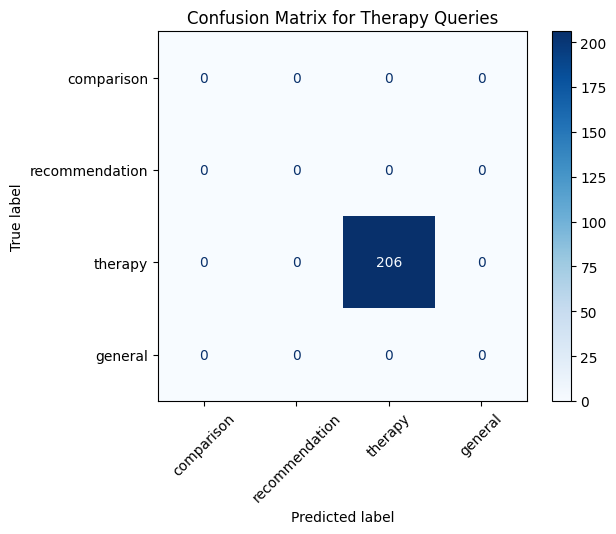

In [67]:
analyze_therapy_queries()

In [68]:
def analyze_label_subset(target_labels):
    """
    Analyze predictions for one or more label subsets.
    
    Args:
        target_labels (str or list): Single label (e.g., "therapy")
                                     or multiple labels (e.g., ["therapy", "recommendation"])
    """

    # Ensure target_labels is a list
    if isinstance(target_labels, str):
        target_labels = [target_labels]

    # Run predictions
    test_results = trainer.predict(test_dataset)

    # Extract logits safely
    raw_preds = test_results.predictions
    logits = raw_preds[0] if isinstance(raw_preds, tuple) else raw_preds

    preds = np.argmax(logits, axis=1)

    # Mask for target label(s)
    subset_mask = test_df['label'].isin(target_labels)
    subset_positions = subset_mask.values

    # Subset predictions + labels
    subset_preds = preds[subset_positions]
    subset_labels = np.array([label2id[l] for l in test_df['label'][subset_positions]])

    logger.info(f"✅ Analysis complete for labels: {target_labels}")
    logger.info(f"🔍 Found {len(subset_preds)} matching predictions.")
    print(f"Predictions shape:", subset_preds.shape)
    print("Sample predictions:", subset_preds[:10])

    # --- Distribution ---
    pred_counts = Counter(subset_preds)
    print(f"\n📊 Predictions class distribution (subset):")
    for class_id, count in pred_counts.items():
        print(f"  {id2label[class_id]}: {count}")

    true_counts = Counter(subset_labels)
    print(f"\n✅ Ground-truth class distribution (subset):")
    for class_id, count in true_counts.items():
        print(f"  {id2label[class_id]}: {count}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(subset_labels, subset_preds, labels=list(id2label.keys()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id2label[i] for i in id2label.keys()])

    plt.figure(figsize=(6, 6))
    disp.plot(cmap="Blues", xticks_rotation=45, values_format="d")
    plt.title(f"Confusion Matrix for {', '.join(target_labels)} Queries")
    plt.show()


c:\Users\user\miniconda3\envs\nut_class_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 26/26 [01:27<00:00,  3.38s/it]
2025-10-14 03:23:04,522 | INFO | ✅ Analysis complete for labels: ['therapy']
2025-10-14 03:23:04,523 | INFO | 🔍 Found 206 matching predictions.


Predictions shape: (206,)
Sample predictions: [2 2 2 2 2 2 2 2 2 2]

📊 Predictions class distribution (subset):
  therapy: 206

✅ Ground-truth class distribution (subset):
  therapy: 206


<Figure size 600x600 with 0 Axes>

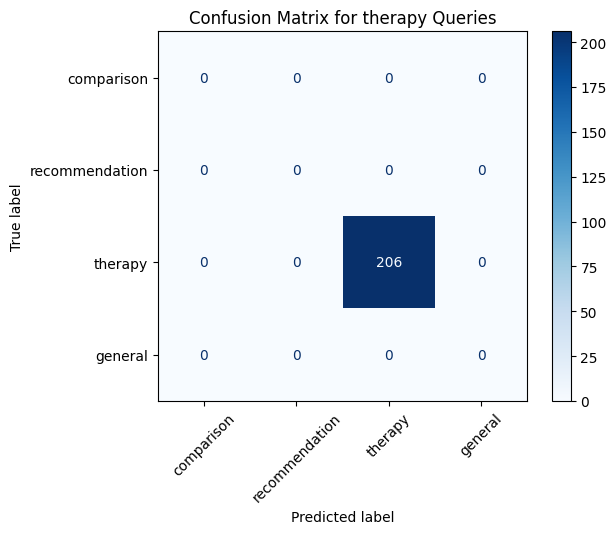

c:\Users\user\miniconda3\envs\nut_class_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 26/26 [01:41<00:00,  3.89s/it]
2025-10-14 03:24:49,020 | INFO | ✅ Analysis complete for labels: ['therapy', 'recommendation', 'comparison']
2025-10-14 03:24:49,020 | INFO | 🔍 Found 650 matching predictions.


Predictions shape: (650,)
Sample predictions: [1 2 0 1 1 0 2 0 1 2]

📊 Predictions class distribution (subset):
  recommendation: 246
  therapy: 206
  comparison: 198

✅ Ground-truth class distribution (subset):
  recommendation: 246
  therapy: 206
  comparison: 198


<Figure size 600x600 with 0 Axes>

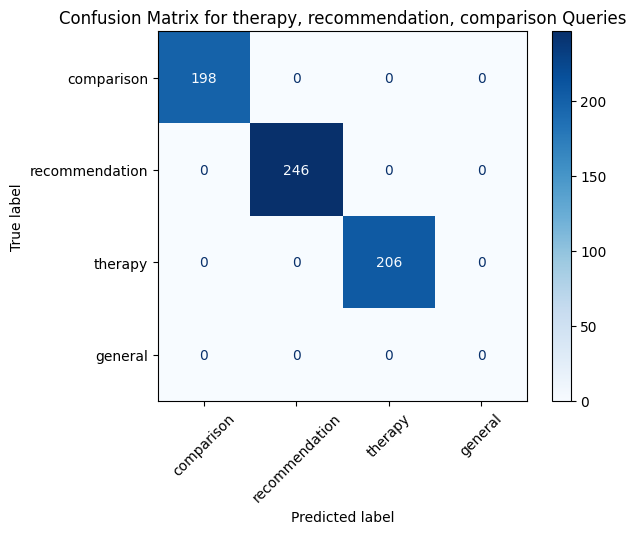

In [69]:
# Single label
analyze_label_subset("therapy")

# Multiple labels
analyze_label_subset(["therapy", "recommendation", "comparison"])


### TESTS

In [70]:
"""# ================================
# 6.1 Launch Training
# ================================
logger.info("🚀 Starting clinical safety training...")
train_results = trainer.train()

# Save model + tokenizer
save_path = "../models/distilbert-clinical-v1-final"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)
logger.info(f"✅ Model and tokenizer saved to {save_path}")"""

'# ================================\n# 6.1 Launch Training\n# ================================\nlogger.info("🚀 Starting clinical safety training...")\ntrain_results = trainer.train()\n\n# Save model + tokenizer\nsave_path = "../models/distilbert-clinical-v1-final"\ntrainer.save_model(save_path)\ntokenizer.save_pretrained(save_path)\nlogger.info(f"✅ Model and tokenizer saved to {save_path}")'

In [71]:
# Pick a training example
idx = 0
sample = train_dataset[idx]

# Decode input_ids back to text
decoded = tokenizer.decode(sample['input_ids'], skip_special_tokens=False)
print("Original query:")
print(train_df.iloc[idx]['query'])
print("\nDecoded tokens:")
print(decoded)

Original query:
Suggest foods from the Food Composition Table rich in vitamin B12 for elderly patients.

Decoded tokens:
[CLS] suggest foods from the food composition table rich in vitamin b12 for elderly patients. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [72]:
# Set model to evaluation mode
model.eval()

# Get one batch from test set
sample_batch = next(iter(trainer.get_eval_dataloader()))

# Move to device
input_ids = sample_batch['input_ids'][:4].to(device)
attention_mask = sample_batch['attention_mask'][:4].to(device)
labels = sample_batch['labels'][:4].cpu().numpy()

# Forward pass
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    # ✅ Fix: Use dict access, not dot access
    logits = outputs['logits'].cpu().numpy()  # ← ['logits'], not .logits
    preds = logits.argmax(-1)

# Print results
print("✅ Model Output Diagnosis")
print("="*50)
for i in range(len(logits)):
    print(f"Sample {i+1}")
    print(f"  Label:     {labels[i]} ({id2label[labels[i]]})")
    print(f"  Prediction: {preds[i]} ({id2label[preds[i]]})")
    print(f"  Logits:    {logits[i].round(3)}")
    print()

c:\Users\user\miniconda3\envs\nut_class_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ Model Output Diagnosis
Sample 1
  Label:     1 (recommendation)
  Prediction: 2 (therapy)
  Logits:    [-1.86  -2.412  5.216 -2.105]

Sample 2
  Label:     2 (therapy)
  Prediction: 3 (general)
  Logits:    [-2.218 -2.381 -1.971  4.636]

Sample 3
  Label:     0 (comparison)
  Prediction: 0 (comparison)
  Logits:    [ 5.621 -1.62  -1.432 -2.007]

Sample 4
  Label:     1 (recommendation)
  Prediction: 2 (therapy)
  Logits:    [-1.88  -2.219  5.172 -2.225]



In [73]:
print("Columns in test_df:", test_df.columns.tolist())

Columns in test_df: ['id', 'query', 'label', 'complexity', 'recommended_llm', 'needs_followup', 'distractor_label', 'biomarkers', 'is_high_risk', 'has_biomarker']


In [74]:
print("label2id:", label2id)
print("Unique labels in train:", train_df['label'].unique())
print("Unique labels in test:", test_df['label'].unique())

label2id: {'comparison': 0, 'recommendation': 1, 'therapy': 2, 'general': 3}
Unique labels in train: ['recommendation' 'general' 'therapy' 'comparison']
Unique labels in test: ['recommendation' 'therapy' 'comparison' 'general']


In [75]:
# Check if special tokens are present in the tokenizer
print("Is [BIOMARKER] in tokenizer?", '[BIOMARKER]' in tokenizer.get_vocab())
print("Is [/BIOMARKER] in tokenizer?", '[/BIOMARKER]' in tokenizer.get_vocab())
print("Is HbA1c in tokenizer?", 'HbA1c' in tokenizer.get_vocab())
print("Tokenizer vocab size:", len(tokenizer))


Is [BIOMARKER] in tokenizer? True
Is [/BIOMARKER] in tokenizer? True
Is HbA1c in tokenizer? True
Tokenizer vocab size: 30528


In [76]:
# Pick a training example
idx = 0
sample = train_dataset[idx]

# Decode input_ids back to text
decoded = tokenizer.decode(sample['input_ids'], skip_special_tokens=False)
print("Original query:")
print(train_df.iloc[idx]['query'])
print("\nDecoded tokens:")
print(decoded)

Original query:
Suggest foods from the Food Composition Table rich in vitamin B12 for elderly patients.

Decoded tokens:
[CLS] suggest foods from the food composition table rich in vitamin b12 for elderly patients. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [77]:
# Pick a training example and decode its tokens correctly
idx = 0

# Get the query text from train_df
query_text = train_df.iloc[idx]['query']

# Tokenize and decode using the same logic as your dataset
encoding = tokenizer(
    query_text,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors=None
)
decoded = tokenizer.decode(encoding['input_ids'], skip_special_tokens=False)

print("Original query:")
print(query_text)
print("\nDecoded tokens:")
print(decoded)

Original query:
Suggest foods from the Food Composition Table rich in vitamin B12 for elderly patients.

Decoded tokens:
[CLS] suggest foods from the food composition table rich in vitamin b12 for elderly patients. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [78]:
df.head(10)

,id,query,label,complexity,recommended_llm,needs_followup,distractor_label,biomarkers,is_high_risk
0,1,Compare the vitamin C content in fresh vs froz...,comparison,2,TinyLlama,True,NaN,[vitamin_c],False
1,2,Which has lower phytate: unfermented ogi or so...,comparison,4,Mistral,True,NaN,[phytate],False
2,3,How much zinc should a 3-year-old child with c...,recommendation,5,Mistral,True,NaN,[zinc],False
3,4,What foods should I eat if I have CKD stage 3 ...,therapy,5,Mistral,False,NaN,[creatinine],True
4,5,Explain how vitamin K helps with blood clotting,general,4,Mistral,False,NaN,[vitamin_k],False
5,6,Compare protein quality of cowpea vs bambara n...,comparison,3,TinyLlama,True,NaN,[protein],False
6,7,What's the recommended daily fiber intake for ...,recommendation,3,Mistral,True,NaN,[fiber],False
7,8,Is palm oil or shea butter better for vitamin ...,comparison,2,TinyLlama,True,NaN,[],False
8,9,Nutrition therapy for hypertension with creati...,therapy,5,Mistral,False,NaN,[creatinine],True
9,10,How does iron get absorbed in the gut?,general,4,Mistral,False,NaN,[iron],False


In [79]:
len(df['is_high_risk'])

4100